# Mount Google Drive and copy data to drive manually

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive/')

Mounted at /content/drive/


# Download 45.7GB Data from nihcc links 

NIH dataset = 112120 chest x-rays with 14 pathology labels from

https://nihcc.app.box.com/v/ChestXray-NIHCC

In [3]:
import urllib.request
from tqdm import tqdm
links = [
    'https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz',
    'https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz',
    'https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz',
	'https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz',
    'https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz',
	
	'https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz',
	'https://nihcc.box.com/shared/static/jn1b4mw4n6lnh74ovmcjb8y48h8xj07n.gz',
    'https://nihcc.box.com/shared/static/tvpxmn7qyrgl0w8wfh9kqfjskv6nmm1j.gz',
	'https://nihcc.box.com/shared/static/upyy3ml7qdumlgk2rfcvlb9k6gvqq2pj.gz',
	'https://nihcc.box.com/shared/static/l6nilvfa9cg3s28tqv1qc1olm3gnz54p.gz',
	'https://nihcc.box.com/shared/static/hhq8fkdgvcari67vfhs7ppg2w6ni4jze.gz',
	'https://nihcc.box.com/shared/static/ioqwiy20ihqwyr8pf4c24eazhh281pbu.gz'
]
for idx, link in tqdm(enumerate(links)):
    fn = 'images_%02d.tar.gz' % (idx+1)
    print ('downloading', fn, '...')
    urllib.request.urlretrieve(link, fn)  # download the zip file
print("Download complete. Please check the checksums")

0it [00:00, ?it/s]

downloading images_01.tar.gz ...


1it [01:50, 110.72s/it]

downloading images_02.tar.gz ...


2it [05:25, 141.97s/it]

downloading images_03.tar.gz ...


3it [09:02, 164.42s/it]

downloading images_04.tar.gz ...


4it [12:33, 178.48s/it]

downloading images_05.tar.gz ...


5it [16:02, 187.52s/it]

downloading images_06.tar.gz ...


6it [19:37, 195.76s/it]

downloading images_07.tar.gz ...


7it [23:02, 198.67s/it]

downloading images_08.tar.gz ...


8it [26:34, 202.61s/it]

downloading images_09.tar.gz ...


9it [30:05, 204.97s/it]

downloading images_10.tar.gz ...


10it [33:46, 209.98s/it]

downloading images_11.tar.gz ...


11it [38:00, 223.23s/it]

downloading images_12.tar.gz ...


12it [40:50, 204.17s/it]

Download complete. Please check the checksums


# Functions 

In [73]:
from glob import glob
from glob import iglob
import shutil
import os
import tarfile
import pandas as pd
import cv2
from tqdm import tqdm
import pickle

def extract_tar_files():

  os.mkdir('./extracted_images')

  for i in ["%.2d" % i for i in range(1,13)]:
    tar = tarfile.open("images_{}.tar.gz".format(i))
    tar.extractall("extracted_images")
    tar.close()
    os.remove("/content/images_{}.tar.gz".format(i))
    print('Extraction of images_{}.tar.gz is Completed and current extracted image count is '.format(i),get_image_count('/content/extracted_images'))

def get_image_count(path):
  folders = glob(path)
  return len(folders)

def build_project(classes):

  # Create below Folder structure 
  # Capstone_Project 
  #    main ==> (16 classes subfolders)
  #    data ==> All images

  os.mkdir('./Capstone_Project')
  os.mkdir('./Capstone_Project/main')
  os.mkdir('/content/Capstone_Project/data')

  # Create 16 subfolders in train and val for each class lables 
  for subfolder in classes:
    os.mkdir('./Capstone_Project/main/{}'.format(subfolder))

def load_orig_metadata(NIH_meta_path='/content/Metadata.csv',COVID19_meta_path='/content/covid-chestxray-dataset/metadata.csv'):

  # Metadata from NIH 

  df_NIH=pd.read_csv(NIH_meta_path)[['Image Index','Finding Labels']]
  df_NIH.rename(columns = {"Finding Labels": "Labels","Image Index":"Image_ID"}, inplace = True) 
  print('NIH Data count = ', df_NIH.shape)

  # Metadata for COVID19

  !git clone https://github.com/ieee8023/covid-chestxray-dataset.git

  df = pd.read_csv(COVID19_meta_path)
  df['Finding Labels'] = 'Covid19'
  df_covid19 = df[df['finding'] == 'Pneumonia/Viral/COVID-19'][['filename','Finding Labels']]
  df_covid19.rename(columns = {"Finding Labels": "Labels","filename":"Image_ID"}, inplace = True) 
  print('Covid19 Data count = ',df_covid19.shape)
  meta_df = pd.concat([df_NIH, df_covid19])
  meta_df.reset_index(inplace=True)
  meta_df.drop('index',inplace=True, axis=1)

  return(meta_df)
  
def sample_dataset(meta_df, sample_count, classes, original_dataset_base_path='/content/extracted_images/images', sample_dataset_main_path='/content/Capstone_Project/main'):

  for iid,lab in tqdm(meta_df.values):
    if lab in classes:                                                                      # Only move images for selected classes
      if '|' not in lab:                                                                    # Filter out only Single Label data
        File = original_dataset_base_path + '/' + iid
        if os.path.exists(File):                                                            # Move only if source file exists
          if not os.path.exists(sample_dataset_main_path + '/' + lab + '/' + iid):          # if dest file already exists, dont move
            if get_image_count(sample_dataset_main_path + '/' + lab + '/*') < sample_count: 
              shutil.move(File, sample_dataset_main_path + '/' + lab + '/')
  for sub in classes:
    count = get_image_count(sample_dataset_main_path + '/{}/*'.format(sub))
    print('Number of sampled images in {} is '.format(sub),count)

def rename_images(main_path='/content/Capstone_Project/main/'):
  
  for sub in os.listdir(r'/content/Capstone_Project/main/'):
    if os.path.isdir(main_path + sub) and not sub.startswith('.'):
      for filepath in iglob(r'/content/Capstone_Project/main/{}/*'.format(sub)):
        old_name = os.path.basename(filepath)
        new_name = '{}_'.format(sub) + old_name.replace(' ','_')
        os.rename(main_path+sub+'/'+old_name,main_path+sub+'/'+new_name)
  print('All images are renamed with its class as prefix')

def build_metadata_dataframe(main_path='/content/Capstone_Project/main/'):
  
  metadata_dict = {}
  metadata_list = []
  for sub in os.listdir(r'/content/Capstone_Project/main/'):
    if os.path.isdir(main_path + sub) and not sub.startswith('.'):
      for filepath in iglob(r'/content/Capstone_Project/main/{}/*'.format(sub)):
        file_name = os.path.basename(filepath)
        metadata_dict['image_id'] = file_name
        metadata_dict['label'] = sub
        metadata_list.append(metadata_dict)
        metadata_dict = {}
  return (pd.DataFrame(metadata_list))

def build_data_for_split(main_path='/content/Capstone_Project/main/', data_path='/content/Capstone_Project/data/'):

  for sub in os.listdir(r'/content/Capstone_Project/main/'):
    if os.path.isdir(main_path + sub) and not sub.startswith('.'):
      for filepath in iglob(r'/content/Capstone_Project/main/{}/*'.format(sub)):
        shutil.copy(filepath, data_path) 
  print('Final Data is Ready and number of images in train folder is ',get_image_count(data_path + '*'))

def convert_images_to_array(metadata_dataframe, image_size=224, data_path='/content/Capstone_Project/data/'):

  x_features=[]
  y_features=[]
  
  for iid,lab in tqdm(metadata_dataframe.values):
    img=cv2.imread((data_path + iid),1)
    img_resize=cv2.resize(img,(image_size,image_size))
    x_features.append(img_resize)
    y_features.append(lab)

  return (x_features,y_features)

# 12 Tar files extraction

In [9]:
extract_tar_files()

Extraction of images_01.tar.gz is sucessful
Extraction of images_02.tar.gz is sucessful
Extraction of images_03.tar.gz is sucessful
Extraction of images_04.tar.gz is sucessful
Extraction of images_05.tar.gz is sucessful
Extraction of images_06.tar.gz is sucessful
Extraction of images_07.tar.gz is sucessful
Extraction of images_08.tar.gz is sucessful
Extraction of images_09.tar.gz is sucessful
Extraction of images_10.tar.gz is sucessful
Extraction of images_11.tar.gz is sucessful
Extraction of images_12.tar.gz is sucessful


In [12]:
get_image_count('/content/extracted_images/images/*')

112120

# Building Project Directory

In [24]:
classes = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia','Covid19','No Finding']

In [27]:
build_project(classes)

# Data Sampling

# Load Original Metadata csv files

In [50]:
meta_df = load_orig_metadata(NIH_meta_path='/content/Metadata.csv',COVID19_meta_path='/content/covid-chestxray-dataset/metadata.csv')
meta_df.tail()

NIH Data count =  (112120, 2)
fatal: destination path 'covid-chestxray-dataset' already exists and is not an empty directory.
Covid19 Data count =  (584, 2)


,Image_ID,Labels
112699,2edb88df42cab5e5fbc18b3965e0bd_jumbo.jpeg,Covid19
112700,16858_1_1.png,Covid19
112701,16858_3_1.png,Covid19
112702,16865_1_1.jpg,Covid19
112703,16865_1_2.jpg,Covid19


In [51]:
meta_df.shape 

(112704, 2)

In [114]:
meta_df.to_csv('original_meta_data.csv')

# Sampling NIH and Covid19 data

In [52]:
sample_dataset(meta_df, 500, classes)

Number of sampled images in Atelectasis is  500
Number of sampled images in Cardiomegaly is  500
Number of sampled images in Effusion is  500
Number of sampled images in Infiltration is  500
Number of sampled images in Mass is  500
Number of sampled images in Nodule is  500
Number of sampled images in Pneumonia is  322
Number of sampled images in Pneumothorax is  500
Number of sampled images in Consolidation is  500
Number of sampled images in Edema is  500
Number of sampled images in Emphysema is  500
Number of sampled images in Fibrosis is  500
Number of sampled images in Pleural_Thickening is  500
Number of sampled images in Hernia is  110
Number of sampled images in Covid19 is  0
Number of sampled images in No Finding is  500


In [53]:
covid_class = ['Covid19']
sample_dataset(meta_df, 500, covid_class, original_dataset_base_path='/content/covid-chestxray-dataset/images')

Number of sampled images in Covid19 is  500


# Renaming images

In [ ]:
rename_images(main_path='/content/Capstone_Project/main/')

# Build Final Metadata Dataframe

In [65]:
final_meta_df = build_metadata_dataframe(main_path='/content/Capstone_Project/main/')

In [68]:
print(final_meta_df.shape)
final_meta_df['label'].value_counts()

(7432, 2)


Effusion              500
Edema                 500
Consolidation         500
Fibrosis              500
Cardiomegaly          500
Pneumothorax          500
Mass                  500
No Finding            500
Emphysema             500
Nodule                500
Infiltration          500
Covid19               500
Atelectasis           500
Pleural_Thickening    500
Pneumonia             322
Hernia                110
Name: label, dtype: int64

In [69]:
final_meta_df.to_csv('final_meta_data.csv')

# Copy all images to /content/Capstone_Project/data/

In [62]:
build_data_for_split(main_path='/content/Capstone_Project/main/', data_path='/content/Capstone_Project/data/')

Final Data is Ready and number of images in train folder is  7432


# Convert Images to array 

In [74]:
x_features,y_features = convert_images_to_array(final_meta_df, 224, data_path='/content/Capstone_Project/data/')

100%|██████████| 7432/7432 [02:18<00:00, 53.48it/s]


In [113]:
pickle.dump(x_features,open('x_features.pkl','wb'))
pickle.dump(y_features,open('y_features.pkl','wb'))

# EDA - 
+ Countplot for class distribution
+ Distribution of area within images using histogram 
+ Plotting Boxes around Images
+ Comparison of all class images with normal images

In [79]:
meta_df.head()

,Image_ID,Labels
0,00000001_000.png,Cardiomegaly
1,00000001_001.png,Cardiomegaly|Emphysema
2,00000001_002.png,Cardiomegaly|Effusion
3,00000002_000.png,No Finding
4,00000003_001.png,Hernia


In [111]:
meta_df[meta_df['Labels'].apply(lambda x: '|' not in x)]['Labels'].value_counts()

No Finding            60361
Infiltration           9547
Atelectasis            4215
Effusion               3955
Nodule                 2705
Pneumothorax           2194
Mass                   2139
Consolidation          1310
Pleural_Thickening     1126
Cardiomegaly           1093
Emphysema               892
Fibrosis                727
Edema                   628
Covid19                 584
Pneumonia               322
Hernia                  110
Name: Labels, dtype: int64

# Data Distribution after sampling

In [81]:
final_meta_df.head()

,image_id,label
0,Edema_00016410_012.png,Edema
1,Edema_00016406_002.png,Edema
2,Edema_00001736_027.png,Edema
3,Edema_00017424_028.png,Edema
4,Edema_00016410_009.png,Edema


In [95]:
count_df = pd.DataFrame(final_meta_df['label'].value_counts())
count_df.reset_index(inplace=True)
count_df.rename(columns = {'index':'pathology', 'label':'count'},inplace=True)
count_df

,pathology,count
0,Effusion,500
1,Edema,500
2,Consolidation,500
3,Fibrosis,500
4,Cardiomegaly,500
5,Pneumothorax,500
6,Mass,500
7,No Finding,500
8,Emphysema,500
9,Nodule,500


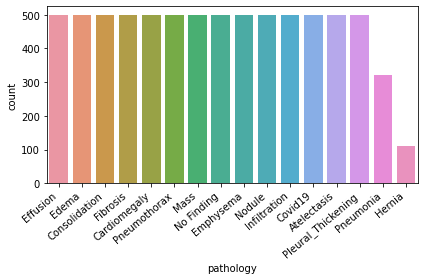

<Figure size 576x288 with 0 Axes>

In [96]:
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.barplot(x="pathology", y='count',data=count_df)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.figure(figsize=(8,4))
plt.show()

# Delete folder/subfolders

In [112]:
#shutil.rmtree('/content/Capstone_Project/main')
#shutil.rmtree('/content/Capstone_Project/data')
#shutil.rmtree('/content/Capstone_Project/extracted_images')
#shutil.rmtree('/content/drive/MyDrive/Capstone_Project/Dataset_250_Images')